In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ks_2samp, ttest_ind
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix

df = pd.read_csv('../0.data/loan_customer.csv')


#히든 데이터셋에 피쳐와 타겟 모두 있음 가정
hd = pd.read_csv('')
hd_ans = hd['TARGET'].copy()
hd.drop('TARGET', axis=1, inplace=True)


In [4]:
df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SK_ID_CURR                  24000 non-null  int64  
 1   NAME_CONTRACT_TYPE          24000 non-null  object 
 2   CODE_GENDER                 16906 non-null  object 
 3   FLAG_OWN_REALTY             14429 non-null  object 
 4   CNT_CHILDREN                24000 non-null  int64  
 5   AMT_INCOME_TOTAL            24000 non-null  float64
 6   AMT_CREDIT                  16700 non-null  float64
 7   NAME_INCOME_TYPE            24000 non-null  object 
 8   NAME_EDUCATION_TYPE         24000 non-null  object 
 9   NAME_FAMILY_STATUS          24000 non-null  object 
 10  NAME_HOUSING_TYPE           24000 non-null  object 
 11  REGION_POPULATION_RELATIVE  16851 non-null  float64
 12  DAYS_BIRTH                  19251 non-null  float64
 13  DAYS_EMPLOYED               168

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,...,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,CB_SCORE_1,CB_SCORE_2,CB_SCORE_3,TARGET
0,100002,Cash loans,M,Y,0,202500.0,NaN,Working,Secondary / secondary special,Single / not married,...,0,0,Business Entity Type 3,0,1,0,NaN,NaN,58.349224,1
1,100004,Revolving loans,NaN,NaN,0,67500.0,135000.0,Working,Secondary / secondary special,Single / not married,...,0,0,Government,0,0,0,26.499494,57.600542,46.433666,0
2,100020,Cash loans,M,N,0,108000.0,509602.5,Working,Secondary / secondary special,Married,...,1,0,Government,0,1,0,NaN,63.496369,NaN,0
3,100029,Cash loans,M,N,2,135000.0,NaN,Working,Secondary / secondary special,Married,...,1,1,Business Entity Type 3,0,1,0,82.376245,45.996152,68.694333,0
4,100048,Cash loans,NaN,Y,0,202500.0,604152.0,Working,Secondary / secondary special,Married,...,1,1,Industry: type 1,0,1,0,66.199985,NaN,NaN,0


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,24000.0,277994.337708,102778.811383,100002.000000,188705.250000,277908.500000,366537.250000,4.562280e+05
CNT_CHILDREN,24000.0,0.418083,0.727194,0.000000,0.000000,0.000000,1.000000,7.000000e+00
AMT_INCOME_TOTAL,24000.0,172518.163586,760460.352545,27000.000000,112500.000000,144000.000000,202500.000000,1.170000e+08
AMT_CREDIT,16700.0,595425.427275,398812.546695,45000.000000,270000.000000,510853.500000,808650.000000,4.050000e+06
REGION_POPULATION_RELATIVE,16851.0,0.020989,0.014061,0.000290,0.010006,0.018850,0.028663,7.250800e-02
DAYS_BIRTH,19251.0,-16026.527453,4365.267387,-25197.000000,-19647.000000,-15731.000000,-12376.500000,-7.688000e+03
DAYS_EMPLOYED,16851.0,63041.865112,140634.051334,-16852.000000,-2772.000000,-1206.000000,-299.000000,3.652430e+05
DAYS_REGISTRATION,14267.0,-5016.930118,3541.618561,-24672.000000,-7537.000000,-4521.000000,-2050.500000,0.000000e+00
DAYS_ID_PUBLISH,19259.0,-2990.491926,1513.089981,-6263.000000,-4308.000000,-3251.000000,-1717.500000,0.000000e+00
FLAG_MOBIL,24000.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00


In [6]:
missing_data = df.isnull().sum()
missing_data_percent = df.isnull().sum() / len(df) * 100

missing_info = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_data_percent})

missing_info = missing_info.sort_values(by='Percentage', ascending=False)

missing_info[missing_info['Missing Values'] > 0]

,Missing Values,Percentage
DAYS_REGISTRATION,9733,40.554167
FLAG_OWN_REALTY,9571,39.879167
CB_SCORE_2,8274,34.475000
AMT_CREDIT,7300,30.416667
REGION_POPULATION_RELATIVE,7149,29.787500
DAYS_EMPLOYED,7149,29.787500
CB_SCORE_3,7108,29.616667
CODE_GENDER,7094,29.558333
CB_SCORE_1,6146,25.608333
DAYS_BIRTH,4749,19.787500


In [7]:
missing_data = df[df['TARGET']==1 ].isnull().sum()
missing_data_percent = (df[df['TARGET']==1].isnull().sum() / len(df)) * 100

missing_info = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_data_percent})

missing_info = missing_info.sort_values(by='Percentage', ascending=False)

missing_info[missing_info['Missing Values'] > 0]


,Missing Values,Percentage
FLAG_OWN_REALTY,834,3.475000
DAYS_REGISTRATION,774,3.225000
CB_SCORE_2,671,2.795833
REGION_POPULATION_RELATIVE,619,2.579167
DAYS_EMPLOYED,612,2.550000
CODE_GENDER,606,2.525000
AMT_CREDIT,602,2.508333
CB_SCORE_1,554,2.308333
CB_SCORE_3,552,2.300000
DAYS_ID_PUBLISH,405,1.687500


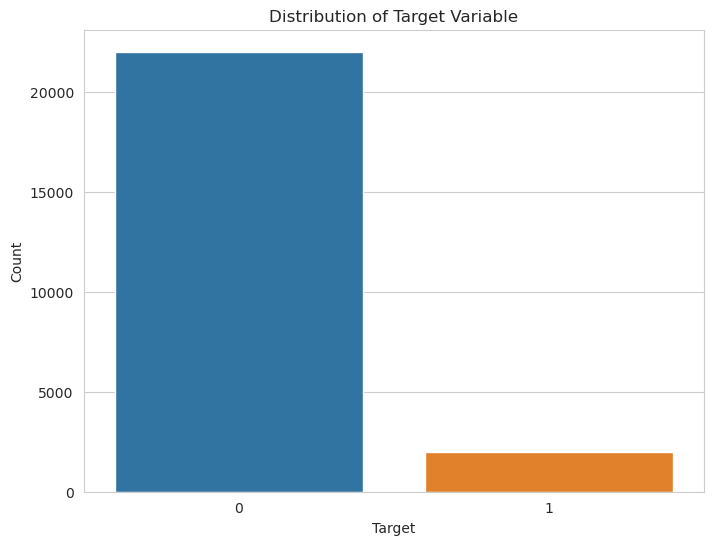

In [8]:
sns.set_style("whitegrid")

plt.figure(figsize=(8, 6))
sns.countplot(x='TARGET', data=df)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

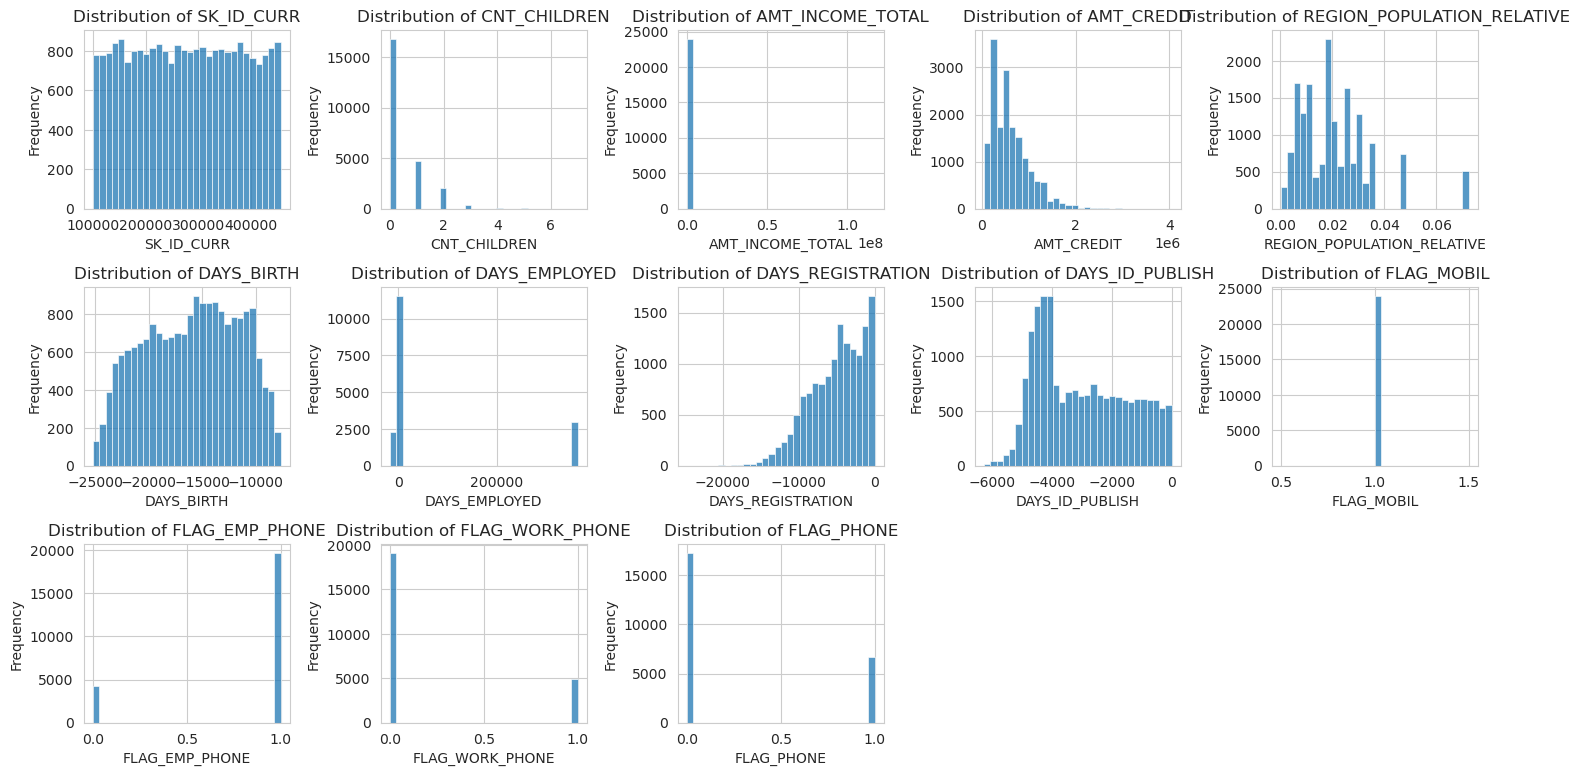

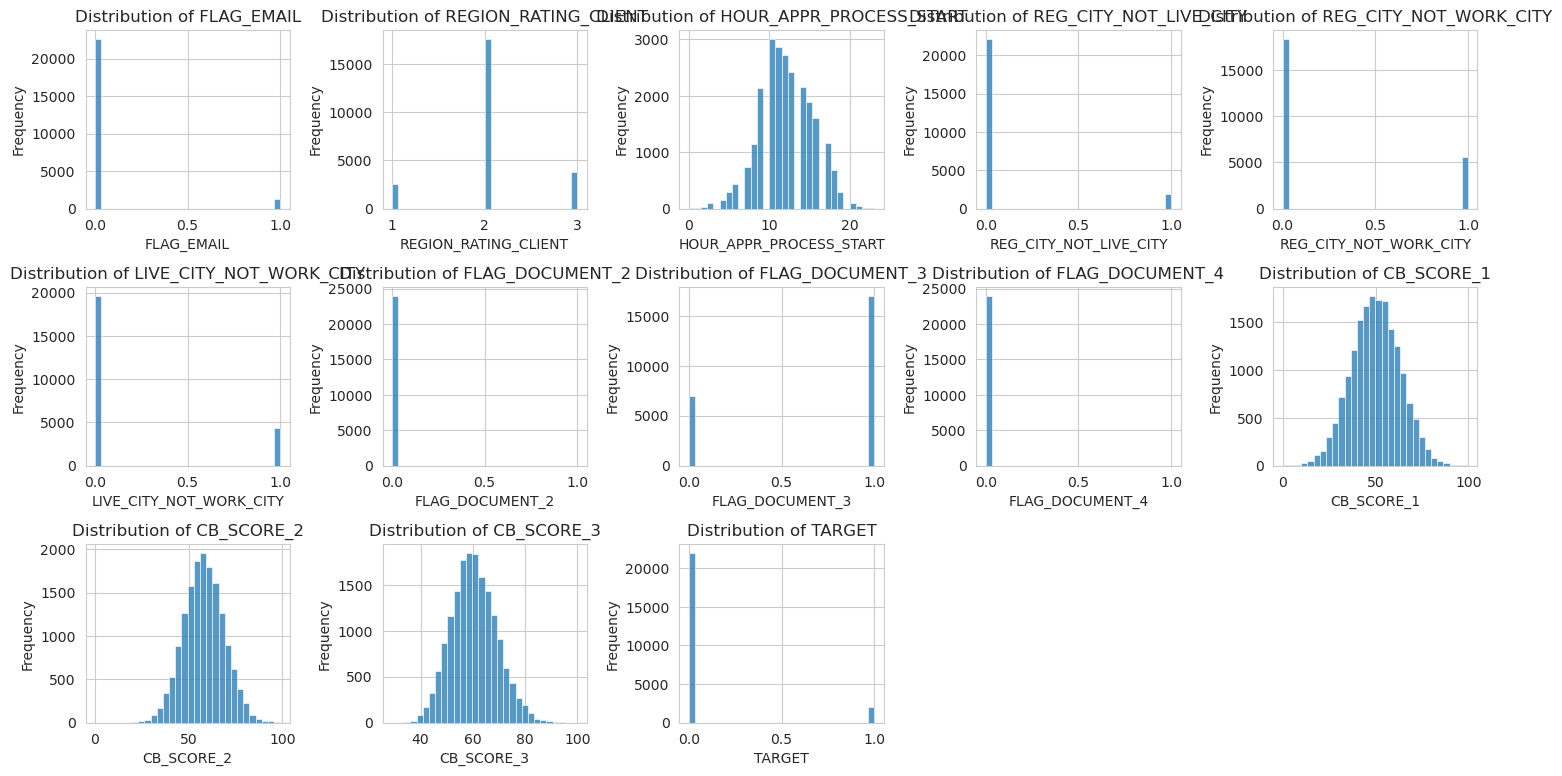

In [9]:
def get_numerical_features(df):
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    return numerical_features

numerical_features = get_numerical_features(df)

plt.figure(figsize=(15, 10))

num_plots = len(numerical_features) // 2
for i, feature in enumerate(numerical_features[:num_plots], 1):
    plt.subplot(4, 5, i)
    sns.histplot(df[feature], bins=30, kde=False)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))

for i, feature in enumerate(numerical_features[num_plots:], 1):
    plt.subplot(4, 5, i)
    sns.histplot(df[feature], bins=30, kde=False)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

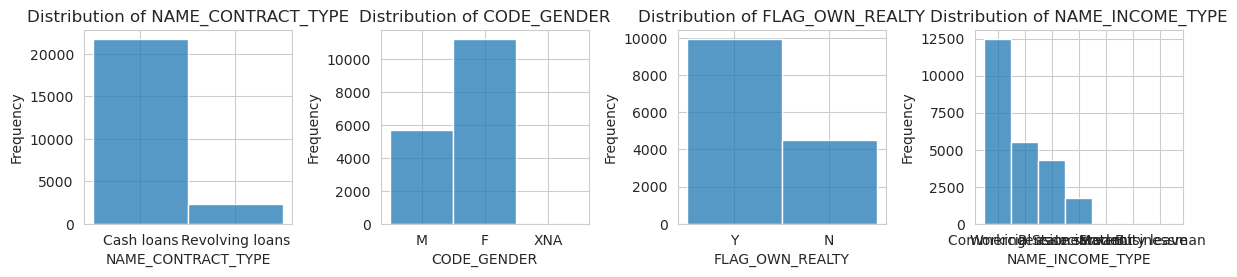

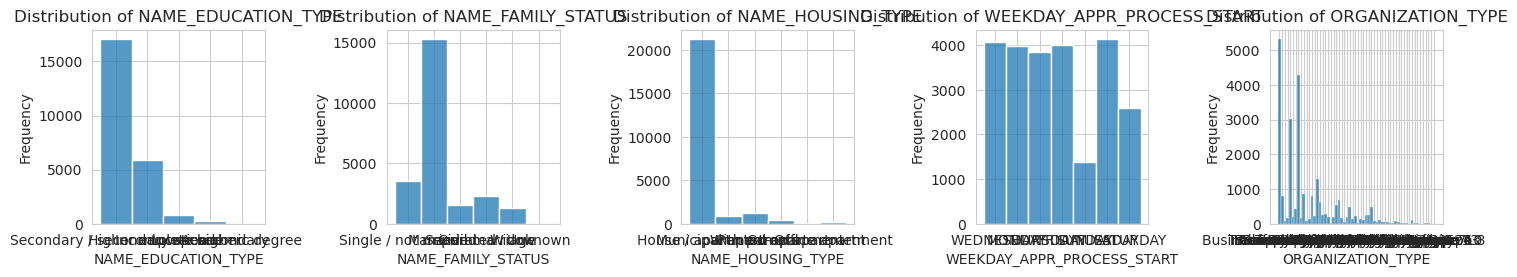

In [10]:
def get_categorical_features(df):
    categorical_features = df.select_dtypes(exclude=[np.number]).columns.tolist()
    return categorical_features

categorical_features = get_categorical_features(df)

plt.figure(figsize=(15, 10))

num_plots = len(categorical_features) // 2
for i, feature in enumerate(categorical_features[:num_plots], 1):
    plt.subplot(4, 5, i)
    sns.histplot(df[feature], bins=30, kde=False)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))

for i, feature in enumerate(categorical_features[num_plots:], 1):
    plt.subplot(4, 5, i)
    sns.histplot(df[feature], bins=30, kde=False)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [11]:
unique_values = df['NAME_INCOME_TYPE'].unique()
unique_count = df['NAME_INCOME_TYPE'].nunique()

unique_values, unique_count

(array(['Working', 'Commercial associate', 'Pensioner', 'State servant',
        'Student', 'Maternity leave', 'Businessman'], dtype=object),
 7)

In [12]:
unique_values = df['NAME_EDUCATION_TYPE'].unique()
unique_count = df['NAME_EDUCATION_TYPE'].nunique()

unique_values, unique_count

(array(['Secondary / secondary special', 'Higher education',
        'Incomplete higher', 'Lower secondary', 'Academic degree'],
       dtype=object),
 5)

In [13]:
unique_values = df['NAME_FAMILY_STATUS'].unique()
unique_count = df['NAME_FAMILY_STATUS'].nunique()

unique_values, unique_count

(array(['Single / not married', 'Married', 'Separated', 'Civil marriage',
        'Widow', 'Unknown'], dtype=object),
 6)

In [14]:
unique_values = df['NAME_HOUSING_TYPE'].unique()
unique_count = df['NAME_HOUSING_TYPE'].nunique()

unique_values, unique_count

(array(['House / apartment', 'Municipal apartment', 'With parents',
        'Rented apartment', 'Co-op apartment', 'Office apartment'],
       dtype=object),
 6)

In [15]:
unique_values = df['ORGANIZATION_TYPE'].unique()
unique_count = df['ORGANIZATION_TYPE'].nunique()

unique_values, unique_count

(array(['Business Entity Type 3', 'Government', 'Industry: type 1',
        'Transport: type 2', 'Self-employed', 'Industry: type 11',
        'Transport: type 4', 'XNA', 'Trade: type 2', 'Medicine', 'Hotel',
        'Services', 'Business Entity Type 2', 'Bank', 'Other',
        'Trade: type 7', 'Industry: type 3', 'Industry: type 9',
        'Agriculture', 'Mobile', 'Police', 'Kindergarten', 'School',
        'Postal', 'Industry: type 5', 'Military', 'Business Entity Type 1',
        'Restaurant', 'Housing', 'Transport: type 1',
        'Security Ministries', 'University', 'Security', 'Trade: type 3',
        'Construction', 'Electricity', 'Trade: type 6',
        'Transport: type 3', 'Telecom', 'Insurance', 'Emergency',
        'Cleaning', 'Industry: type 2', 'Industry: type 4', 'Advertising',
        'Legal Services', 'Industry: type 12', 'Trade: type 1',
        'Trade: type 5', 'Industry: type 7', 'Culture', 'Industry: type 6',
        'Industry: type 13', 'Industry: type 10', 'Tr

In [16]:
object_columns = df.select_dtypes(include=['object']).columns

relationship_with_target_counts = {}

for col in object_columns:
    relationship_df = df.groupby(col)['TARGET'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
    relationship_with_target_counts[col] = relationship_df

for col, relationship_df in relationship_with_target_counts.items():
    print(f"Updated Relationship and Counts for {col}:")
    display(relationship_df)
    print("\n" + "="*50 + "\n")

Updated Relationship and Counts for NAME_CONTRACT_TYPE:


,mean,count
NAME_CONTRACT_TYPE,,
Cash loans,0.085952,21733
Revolving loans,0.055139,2267




Updated Relationship and Counts for CODE_GENDER:


,mean,count
CODE_GENDER,,
M,0.104847,5694
F,0.070467,11211
XNA,0.000000,1




Updated Relationship and Counts for FLAG_OWN_REALTY:


,mean,count
FLAG_OWN_REALTY,,
N,0.081737,4490
Y,0.079686,9939




Updated Relationship and Counts for NAME_INCOME_TYPE:


,mean,count
NAME_INCOME_TYPE,,
Working,0.100401,12460
Commercial associate,0.072734,5527
Pensioner,0.058919,4294
State servant,0.050758,1714
Businessman,0.000000,1
Maternity leave,0.000000,2
Student,0.000000,2




Updated Relationship and Counts for NAME_EDUCATION_TYPE:


,mean,count
NAME_EDUCATION_TYPE,,
Lower secondary,0.093525,278
Secondary / secondary special,0.093292,17054
Incomplete higher,0.076633,796
Higher education,0.053782,5857
Academic degree,0.000000,15




Updated Relationship and Counts for NAME_FAMILY_STATUS:


,mean,count
NAME_FAMILY_STATUS,,
Civil marriage,0.110445,2336
Single / not married,0.105707,3557
Separated,0.080550,1527
Married,0.075352,15275
Widow,0.065184,1304
Unknown,0.000000,1




Updated Relationship and Counts for NAME_HOUSING_TYPE:


,mean,count
NAME_HOUSING_TYPE,,
Rented apartment,0.148338,391
With parents,0.131841,1206
Municipal apartment,0.092206,911
Co-op apartment,0.078947,76
House / apartment,0.078867,21213
Office apartment,0.064039,203




Updated Relationship and Counts for WEEKDAY_APPR_PROCESS_START:


,mean,count
WEEKDAY_APPR_PROCESS_START,,
TUESDAY,0.090447,4135
SATURDAY,0.085648,2592
THURSDAY,0.085090,3843
FRIDAY,0.083104,3995
WEDNESDAY,0.082535,4071
SUNDAY,0.076424,1387
MONDAY,0.074428,3977




Updated Relationship and Counts for ORGANIZATION_TYPE:


,mean,count
ORGANIZATION_TYPE,,
Trade: type 5,0.250000,4
Industry: type 13,0.200000,5
Legal Services,0.148148,27
Emergency,0.147541,61
Trade: type 4,0.142857,7
Industry: type 3,0.140625,256
Industry: type 1,0.134831,89
Transport: type 3,0.121212,99
Agriculture,0.118812,202


In [17]:
numerical_df = df.select_dtypes(include=['number'])
correlation_with_target_numerical = numerical_df.corr()['TARGET'].sort_values(ascending=False)

correlation_with_target_numerical

TARGET                        1.000000
CB_SCORE_1                    0.129019
DAYS_BIRTH                    0.084192
REGION_RATING_CLIENT          0.065444
REG_CITY_NOT_WORK_CITY        0.062075
REG_CITY_NOT_LIVE_CITY        0.047905
FLAG_DOCUMENT_3               0.047013
DAYS_ID_PUBLISH               0.044937
FLAG_EMP_PHONE                0.040806
LIVE_CITY_NOT_WORK_CITY       0.039849
DAYS_REGISTRATION             0.031433
FLAG_WORK_PHONE               0.028155
AMT_INCOME_TOTAL              0.017482
CNT_CHILDREN                  0.014485
FLAG_DOCUMENT_4              -0.003365
FLAG_DOCUMENT_2              -0.003885
SK_ID_CURR                   -0.010031
FLAG_EMAIL                   -0.010649
CB_SCORE_2                   -0.011226
CB_SCORE_3                   -0.018678
AMT_CREDIT                   -0.020573
FLAG_PHONE                   -0.021980
HOUR_APPR_PROCESS_START      -0.028058
DAYS_EMPLOYED                -0.040092
REGION_POPULATION_RELATIVE   -0.043568
FLAG_MOBIL               

In [18]:
missing_data = df.isnull().sum()
missing_data_percent = (df.isnull().sum() / len(df)) * 100

missing_info = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_data_percent})

missing_info = missing_info.sort_values(by='Percentage', ascending=False)

missing_info[missing_info['Missing Values'] > 0]

,Missing Values,Percentage
DAYS_REGISTRATION,9733,40.554167
FLAG_OWN_REALTY,9571,39.879167
CB_SCORE_2,8274,34.475000
AMT_CREDIT,7300,30.416667
REGION_POPULATION_RELATIVE,7149,29.787500
DAYS_EMPLOYED,7149,29.787500
CB_SCORE_3,7108,29.616667
CODE_GENDER,7094,29.558333
CB_SCORE_1,6146,25.608333
DAYS_BIRTH,4749,19.787500


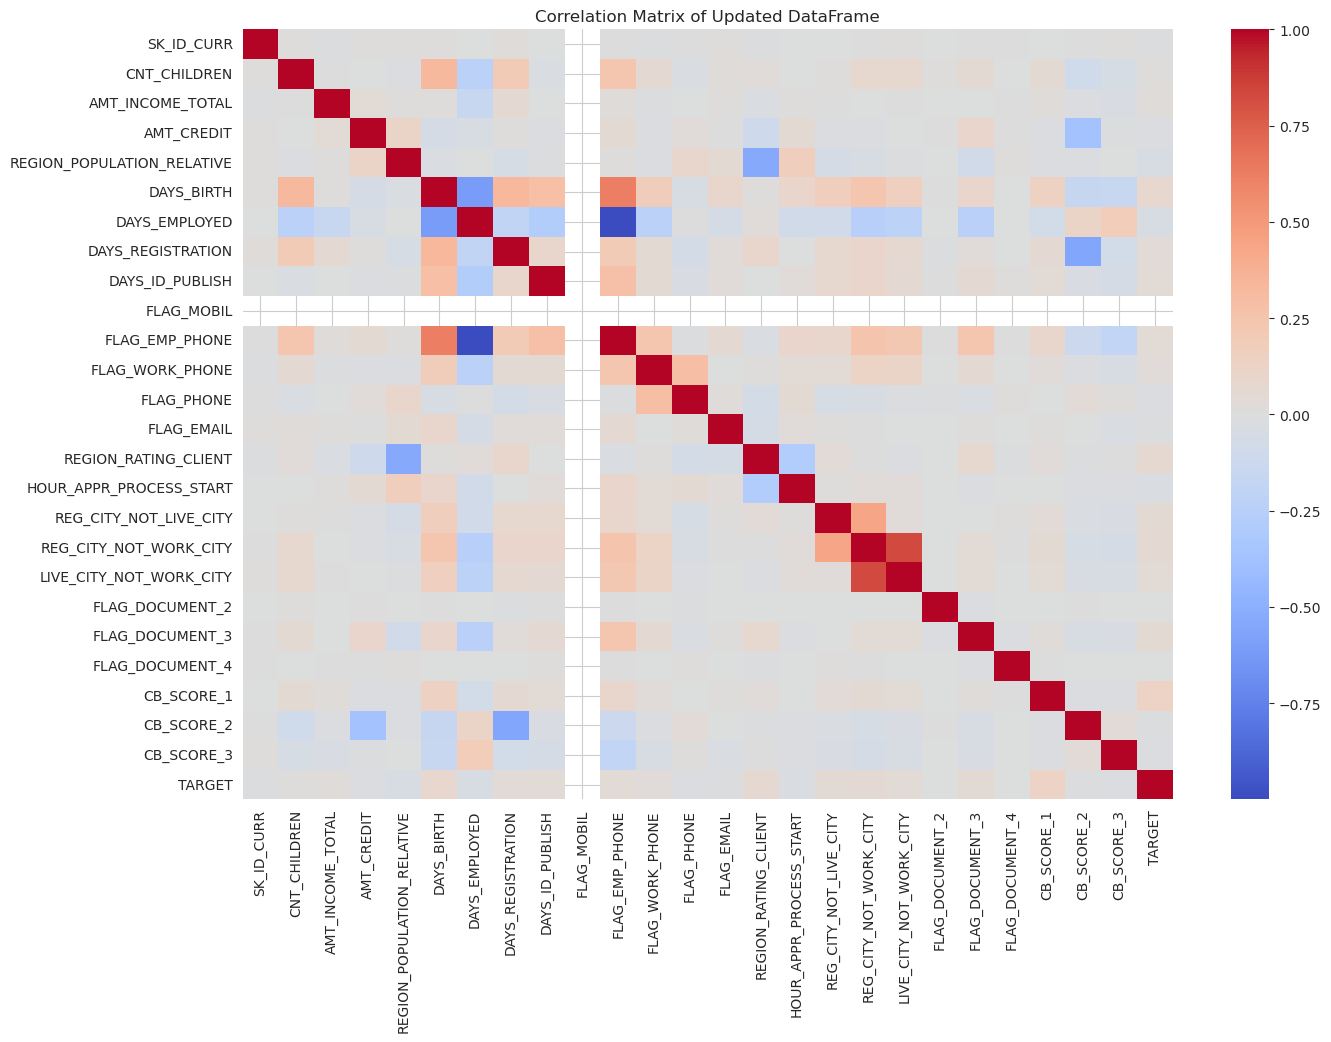

In [19]:
updated_numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
updated_correlation_matrix = df[updated_numerical_columns].corr()

plt.figure(figsize=(15, 10))
sns.heatmap(updated_correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Updated DataFrame')
plt.show()

In [20]:
def prep(df):
    df['AMT_INCOME_TOTAL'] = df['AMT_INCOME_TOTAL'].apply(lambda x: min(x, 270000))

    days_columns = [col for col in df.columns if col.startswith('DAYS_')]
    df[days_columns] = df[days_columns].apply(np.abs)

    job_mapping = {
    'Transport': ['Transport: type 1', 'Transport: type 2', 'Transport: type 3', 'Transport: type 4'],
    'Trade': ['Trade: type 1', 'Trade: type 2', 'Trade: type 3', 'Trade: type 4', 'Trade: type 5', 'Trade: type 6', 'Trade: type 7'],
    'Industry': ['Industry: type 1', 'Industry: type 10', 'Industry: type 11', 'Industry: type 12', 'Industry: type 13', 'Industry: type 2', 'Industry: type 3', 'Industry: type 4', 'Industry: type 5', 'Industry: type 6', 'Industry: type 7', 'Industry: type 8', 'Industry: type 9', 'Restaurant'],
    'Business1': ['Business Entity Type 1'],
    'Business2': ['Business Entity Type 2'],
    'Business3': ['Business Entity Type 3'],
    'Decent': ['Bank', 'Culture', 'Legal Services', 'Medicine', 'Military', 'Police', 'XNA'],
    'Labor': ['Agriculture', 'Cleaning', 'Construction', 'Realtor'],
    'Self_emp': ['Self-employed'],
    'Servicer': ['Hotel', 'Insurance', 'Services', 'Telecom'],
    'Scholar': ['Religion', 'School', 'Security Ministries', 'University'],
    'MobSec': ['Mobile', 'Security'],
    'Others': ['Advertising', 'Electricity', 'Emergency', 'Government', 'Housing', 'Other', 'Postal'],
    'Kinder': ['Kindergarten']
    }
    df['job_columns'] = None
    for job, org_types in job_mapping.items():
        df.loc[df['ORGANIZATION_TYPE'].isin(org_types), 'job_columns'] = job

    job_class_mapping = {'MobSec': 13
               , 'Labor': 12
               , 'Self_emp': 11
               , 'Trade': 10
               , 'Industry': 9
               , 'Others': 8
               , 'Business3': 7
               , 'Transport': 6
               , 'Business2': 5
               , 'Business1': 4
               , 'Kinder': 3
               , 'Scholar': 2
               , 'Decent': 1
               , 'Servicer': 0
              }
    df['job_columns'] = df['job_columns'].map(job_class_mapping)
    df.drop('ORGANIZATION_TYPE', axis=1, inplace=True)

    df['CODE_GENDER'].replace('XNA', 'F', inplace=True)
    df['NAME_INCOME_TYPE'].replace('Businessman', 'Commercial associate', inplace=True)
    df['NAME_FAMILY_STATUS'].replace('Unknown', 'Married', inplace=True)
    df['NAME_INCOME_TYPE'].replace('Maternity leave', 'Working', inplace=True)
    df['NAME_INCOME_TYPE'].replace('Student' ,'State servant', inplace=True)
    df['NAME_HOUSING_TYPE'].replace('Co-op apartment', 'House / apartment', inplace=True)

    gender_mapping = {'F': 0, 'M': 1}
    df['CODE_GENDER'] = df['CODE_GENDER'].map(gender_mapping)

    realty_mapping = { 'Y' : 0, 'N' : 1}
    df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].map(realty_mapping)

    contract_mapping = {'Cash loans': 1, 'Revolving loans': 0}
    df['NAME_CONTRACT_TYPE'] = df['NAME_CONTRACT_TYPE'].map(contract_mapping)

    income_mapping = { 'Working' : 3
                      ,'Commercial associate' : 2
                      ,'Pensioner' : 1
                      ,'State servant' : 0
    }
    df['NAME_INCOME_TYPE'] = df['NAME_INCOME_TYPE'].map(income_mapping)

    education_mapping = { 'Lower secondary' : 4
                         ,'Secondary / secondary special' : 3
                         ,'Incomplete higher' : 2
                         ,'Higher education' : 1
                         ,'Academic degree' : 0
    }
    df['NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].map(education_mapping)

    family_mapping = { 'Civil marriage' : 4
                      ,'Single / not married' : 3
                      ,'Separated' : 2
                      ,'Married' : 1
                      ,'Widow' : 0
    }
    df['NAME_FAMILY_STATUS'] = df['NAME_FAMILY_STATUS'].map(family_mapping)

    housing_mapping = { 'Rented apartment' : 4
                       ,'With parents' : 3
                       ,'Municipal apartment' : 2
                       ,'House / apartment' : 1
                       ,'Office apartment' : 0
    }
    df['NAME_HOUSING_TYPE'] = df['NAME_HOUSING_TYPE'].map(housing_mapping)

    weekday_mapping  = { 'SUNDAY' : 0
                        ,'MONDAY' : 1
                        ,'TUESDAY' : 1
                        ,'WEDNESDAY' : 1
                        ,'THURSDAY' : 1
                        ,'FRIDAY' : 1
                        ,'SATURDAY' : 0
    }
    df['WEEKDAY_APPR_PROCESS_START'] = df['WEEKDAY_APPR_PROCESS_START'].map(weekday_mapping)

    df.drop('FLAG_DOCUMENT_2', axis=1, inplace=True)
    df.drop('FLAG_DOCUMENT_4', axis=1, inplace=True)
    df.drop('FLAG_MOBIL', axis=1, inplace=True)

    df['flag_LIVE'] = np.array([f"{c1}{c2}{c3}" for c1, c2, c3 in zip(df['REG_CITY_NOT_LIVE_CITY'], df['REG_CITY_NOT_WORK_CITY'], df['LIVE_CITY_NOT_WORK_CITY'])])
    live_mapping = { '000' : 1
                    ,'001' : 2
                    ,'010' : 3
                    ,'011' : 4
                    ,'100' : 5
                    ,'101' : 6
                    ,'110' : 7
                    ,'111' : 8
    }
    df['flag_LIVE'] = df['flag_LIVE'].map(live_mapping)
    df.drop(['REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY'], axis=1, inplace=True)

    df['flag_P'] = np.array([f"{c1}{c2}{c3}{c4}" for c1, c2, c3, c4 in zip(df['FLAG_EMP_PHONE'], df['FLAG_WORK_PHONE'], df['FLAG_PHONE'], df['FLAG_EMAIL'])])
    flag_P_mapping = {  '0000' : 1
                       ,'0001' : 2
                       ,'0010' : 3
                       ,'0011' : 4
                       ,'0100' : 5
                       ,'0101' : 6
                       ,'0110' : 7
                       ,'0111' : 8

                       ,'1000' : 9
                       ,'1001' : 10
                       ,'1010' : 11
                       ,'1011' : 12
                       ,'1100' : 13
                       ,'1101' : 14
                       ,'1110' : 15
                       ,'1111' : 16
    }
    df['flag_P'] = df['flag_P'].map(flag_P_mapping)
    df.drop(['FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL'], axis=1, inplace=True)

    def get_child_label(cnt_children):
        if cnt_children < 1: return 3
        elif cnt_children < 3: return 2
        else: return 1
    df['child_RANGE'] = df['CNT_CHILDREN'].apply(lambda x: get_child_label(x))
    df.drop('CNT_CHILDREN', axis=1, inplace=True)

    def get_hour_label(HOUR_APPR_PROCESS_START):
        if HOUR_APPR_PROCESS_START < 8: return 3
        elif HOUR_APPR_PROCESS_START < 15: return 2
        else: return 1
    df['hour_RANGE'] = df['HOUR_APPR_PROCESS_START'].apply(lambda x: get_child_label(x))
    df.drop('HOUR_APPR_PROCESS_START', axis=1, inplace=True)


    return df

In [21]:
df = prep(df)

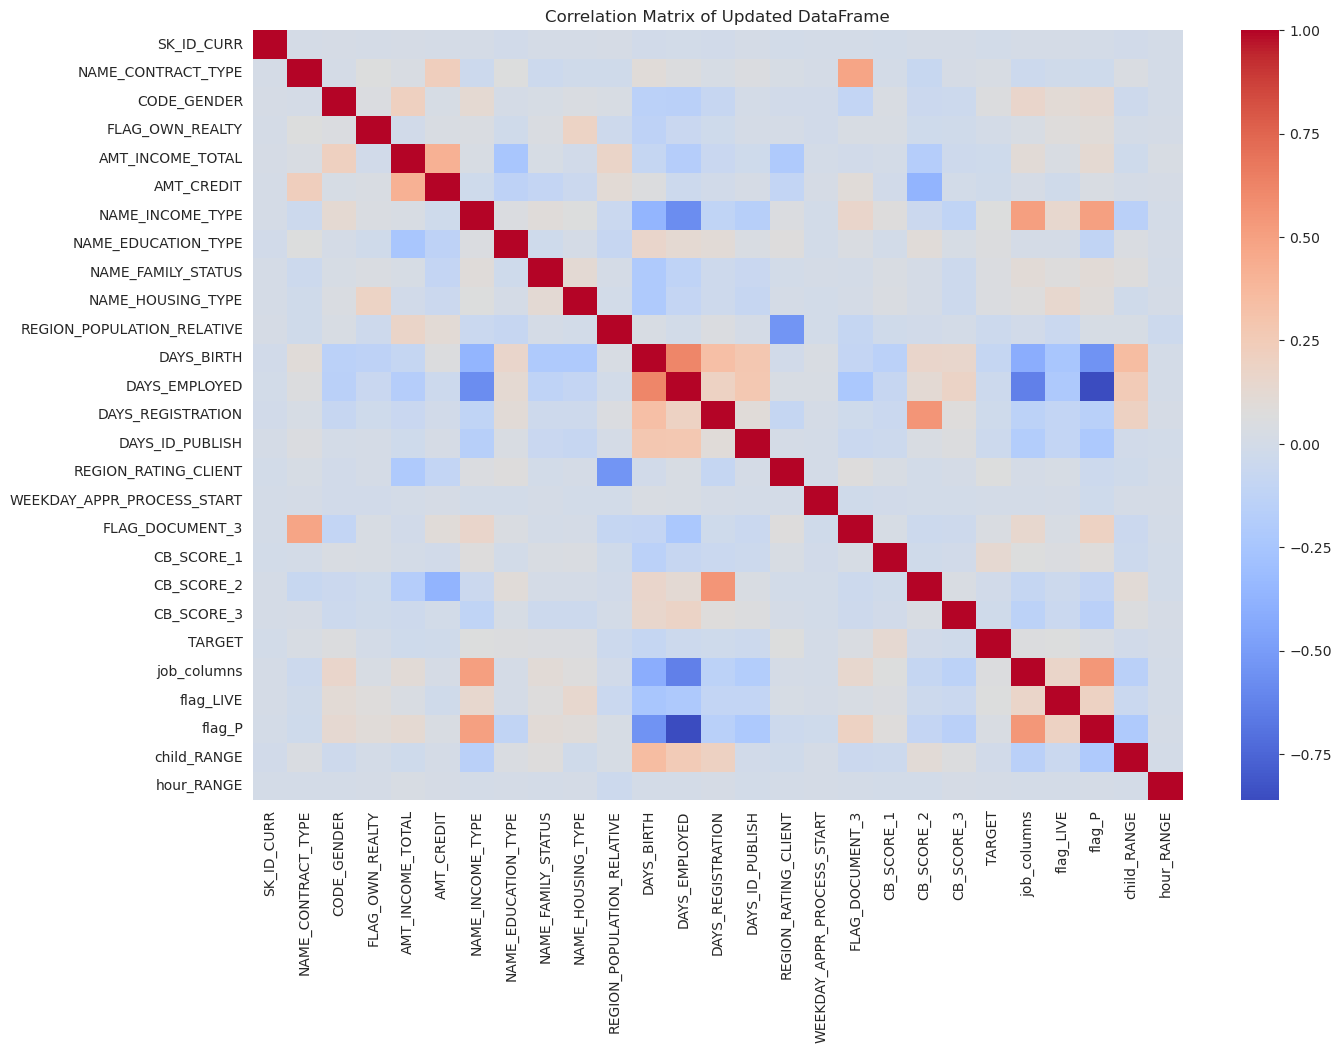

In [22]:
updated_numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
updated_correlation_matrix = df[updated_numerical_columns].corr()

plt.figure(figsize=(15, 10))
sns.heatmap(updated_correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Updated DataFrame')
plt.show()

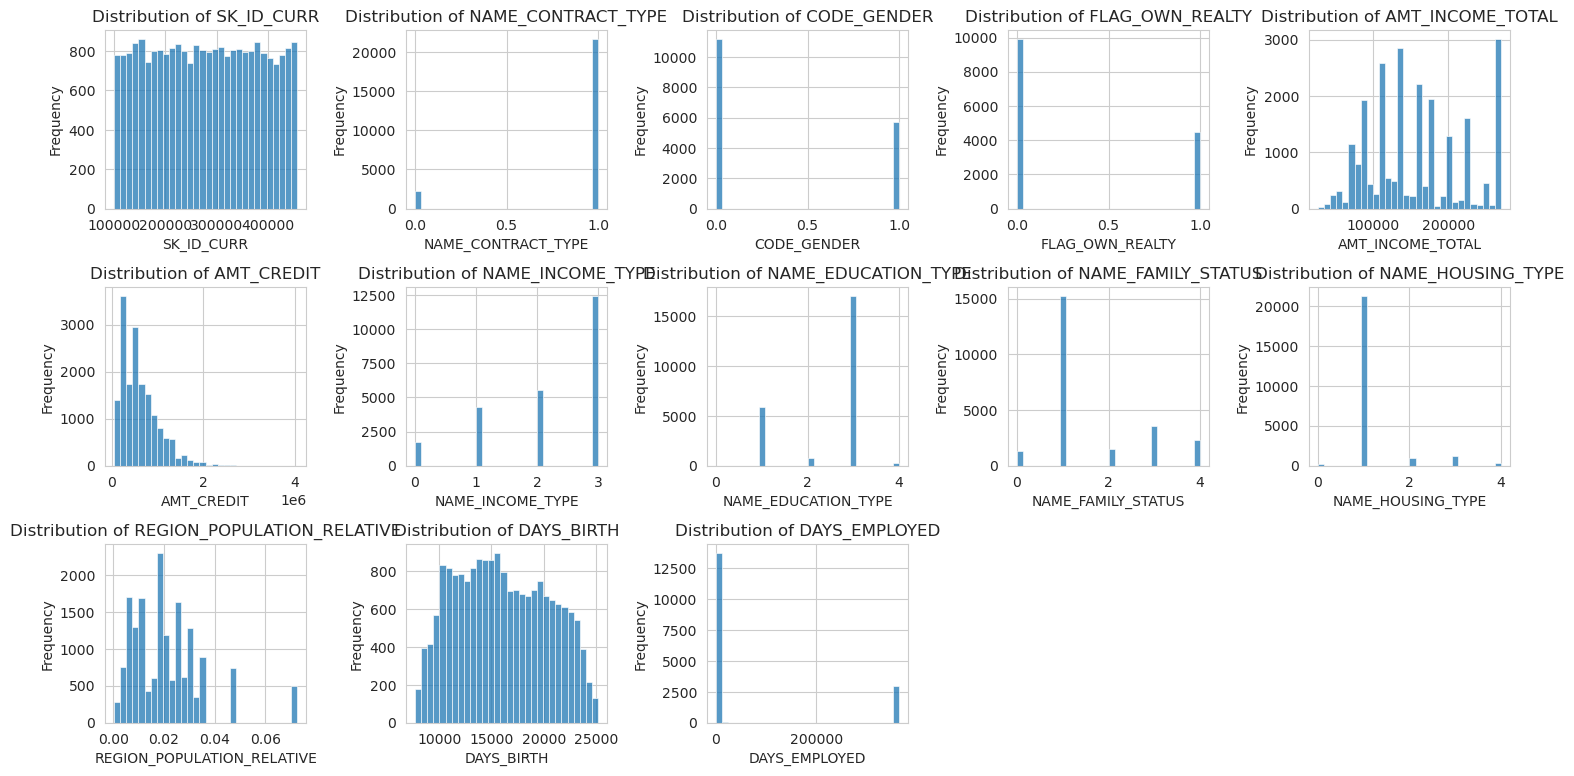

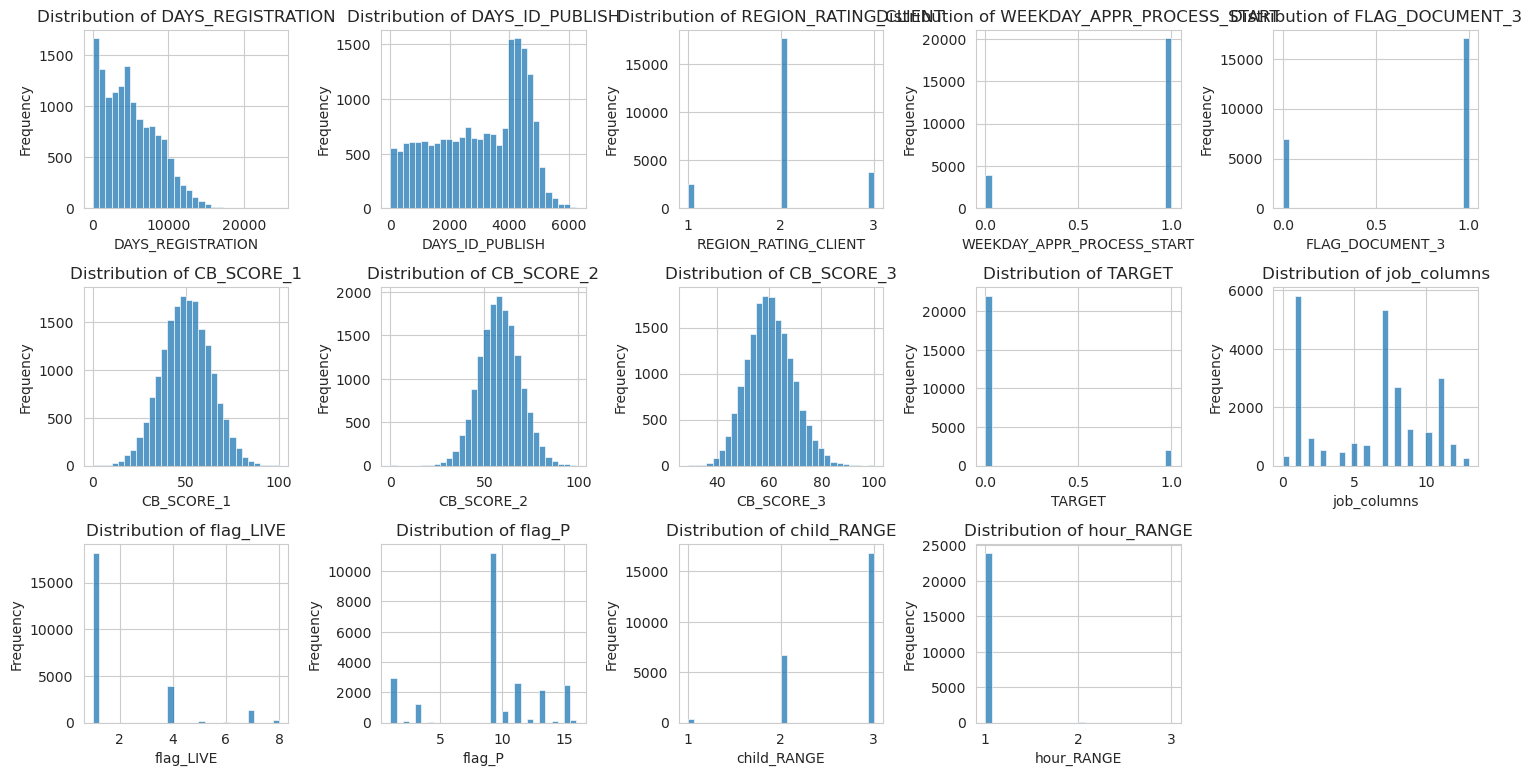

In [23]:
def get_numerical_features(df):
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    return numerical_features

numerical_features = get_numerical_features(df)

plt.figure(figsize=(15, 10))

num_plots = len(numerical_features) // 2
for i, feature in enumerate(numerical_features[:num_plots], 1):
    plt.subplot(4, 5, i)
    sns.histplot(df[feature], bins=30, kde=False)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))

for i, feature in enumerate(numerical_features[num_plots:], 1):
    plt.subplot(4, 5, i)
    sns.histplot(df[feature], bins=30, kde=False)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [24]:
numerical_df = df.select_dtypes(include=['number'])
correlation_with_target_numerical = numerical_df.corr()['TARGET'].sort_values(ascending=False)

correlation_with_target_numerical

TARGET                        1.000000
CB_SCORE_1                    0.129019
NAME_INCOME_TYPE              0.066894
REGION_RATING_CLIENT          0.065444
flag_LIVE                     0.064912
NAME_EDUCATION_TYPE           0.061206
job_columns                   0.059929
CODE_GENDER                   0.059221
NAME_HOUSING_TYPE             0.051821
NAME_FAMILY_STATUS            0.050761
FLAG_DOCUMENT_3               0.047013
flag_P                        0.037008
NAME_CONTRACT_TYPE            0.032658
hour_RANGE                    0.004249
FLAG_OWN_REALTY               0.003494
WEEKDAY_APPR_PROCESS_START    0.000984
SK_ID_CURR                   -0.010031
CB_SCORE_2                   -0.011226
child_RANGE                  -0.015295
CB_SCORE_3                   -0.018678
AMT_CREDIT                   -0.020573
AMT_INCOME_TOTAL             -0.027258
DAYS_REGISTRATION            -0.031433
DAYS_EMPLOYED                -0.042246
REGION_POPULATION_RELATIVE   -0.043568
DAYS_ID_PUBLISH          

In [25]:
df = df.dropna(subset=['CB_SCORE_1'])

In [26]:
filtered_df = df.dropna(subset=['DAYS_EMPLOYED'
                               ,'DAYS_ID_PUBLISH'
                               ,'CODE_GENDER'
                               ,'DAYS_BIRTH'
                               ])

df_target_1 = filtered_df[filtered_df['TARGET'] == 1]
df_target_0 = filtered_df[filtered_df['TARGET'] == 0]

df_target_1_sample = df_target_1.sample(n=150, random_state=192)
df_target_0_sample = df_target_0.sample(n=1700, random_state=192)

valid_set = pd.concat([df_target_1_sample, df_target_0_sample], ignore_index=True)
valid_set_ids = valid_set['SK_ID_CURR'].values
train_set = df[~df['SK_ID_CURR'].isin(valid_set_ids)]

In [27]:
train_set.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,16004.0,277732.357723,102863.799231,100004.000000,188447.750000,277672.500000,366573.750000,4.562280e+05
NAME_CONTRACT_TYPE,16004.0,0.904649,0.293709,0.000000,1.000000,1.000000,1.000000,1.000000e+00
CODE_GENDER,10739.0,0.337927,0.473026,0.000000,0.000000,0.000000,1.000000,1.000000e+00
FLAG_OWN_REALTY,9660.0,0.316874,0.465282,0.000000,0.000000,0.000000,1.000000,1.000000e+00
AMT_INCOME_TOTAL,16004.0,157484.117694,63933.458773,27000.000000,112500.000000,144000.000000,202500.000000,2.700000e+05
AMT_CREDIT,11152.0,598863.417369,400236.380840,45000.000000,270000.000000,517500.000000,808650.000000,3.150000e+06
NAME_INCOME_TYPE,16004.0,2.199950,0.971897,0.000000,2.000000,3.000000,3.000000,3.000000e+00
NAME_EDUCATION_TYPE,16004.0,2.488378,0.875091,0.000000,2.000000,3.000000,3.000000,4.000000e+00
NAME_FAMILY_STATUS,16004.0,1.603349,1.111878,0.000000,1.000000,1.000000,2.000000,4.000000e+00
NAME_HOUSING_TYPE,16004.0,1.179705,0.604053,0.000000,1.000000,1.000000,1.000000,4.000000e+00


In [28]:
valid_set.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,1850.0,278830.463243,103180.363550,100277.000000,190525.000000,276516.500000,369438.500000,4.560180e+05
NAME_CONTRACT_TYPE,1850.0,0.905946,0.291983,0.000000,1.000000,1.000000,1.000000,1.000000e+00
CODE_GENDER,1850.0,0.330270,0.470438,0.000000,0.000000,0.000000,1.000000,1.000000e+00
FLAG_OWN_REALTY,1097.0,0.296263,0.456816,0.000000,0.000000,0.000000,1.000000,1.000000e+00
AMT_INCOME_TOTAL,1850.0,157232.987027,64497.272359,27000.000000,112500.000000,148500.000000,202500.000000,2.700000e+05
AMT_CREDIT,1281.0,585295.204918,391069.584892,45000.000000,270000.000000,508495.500000,797557.500000,3.600000e+06
NAME_INCOME_TYPE,1850.0,2.209730,0.980785,0.000000,2.000000,3.000000,3.000000,3.000000e+00
NAME_EDUCATION_TYPE,1850.0,2.475676,0.879859,0.000000,2.000000,3.000000,3.000000,4.000000e+00
NAME_FAMILY_STATUS,1850.0,1.593514,1.113932,0.000000,1.000000,1.000000,2.000000,4.000000e+00
NAME_HOUSING_TYPE,1850.0,1.179459,0.613715,0.000000,1.000000,1.000000,1.000000,4.000000e+00


<Figure size 640x480 with 0 Axes>

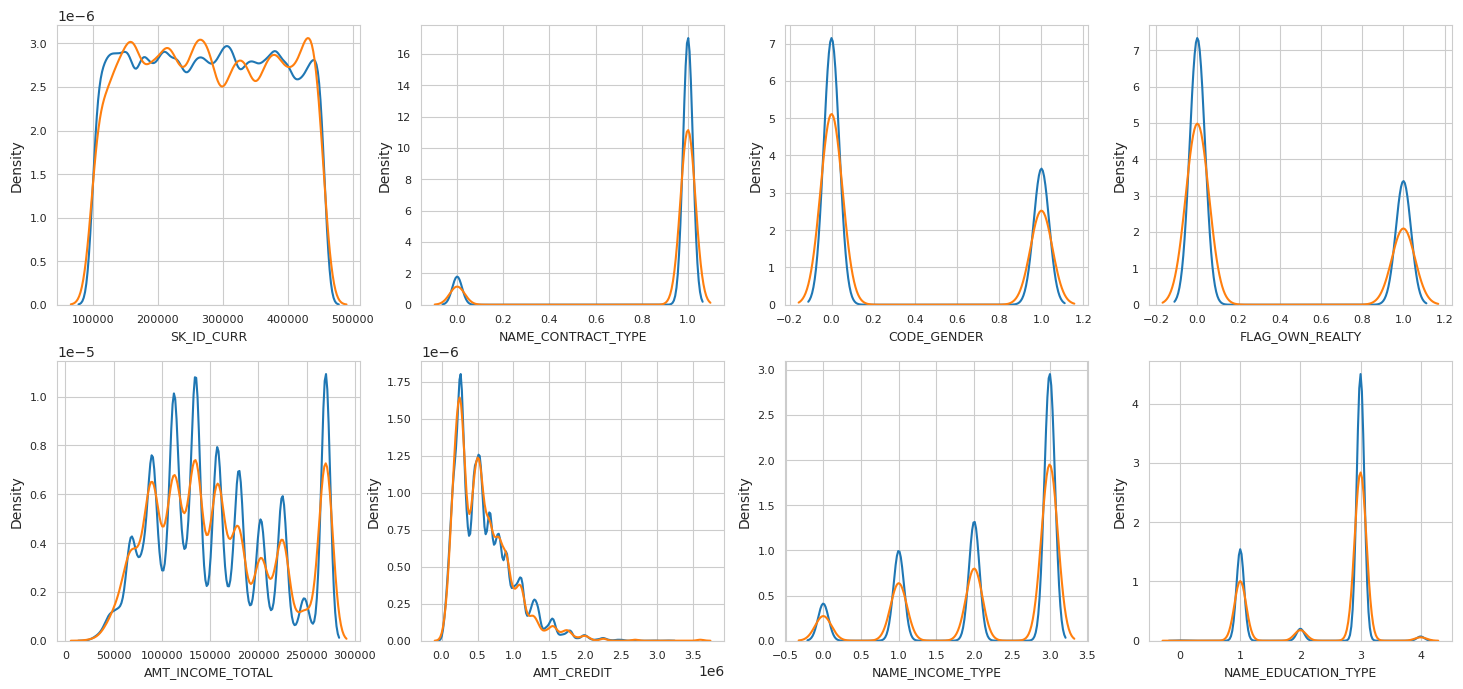

<Figure size 640x480 with 0 Axes>

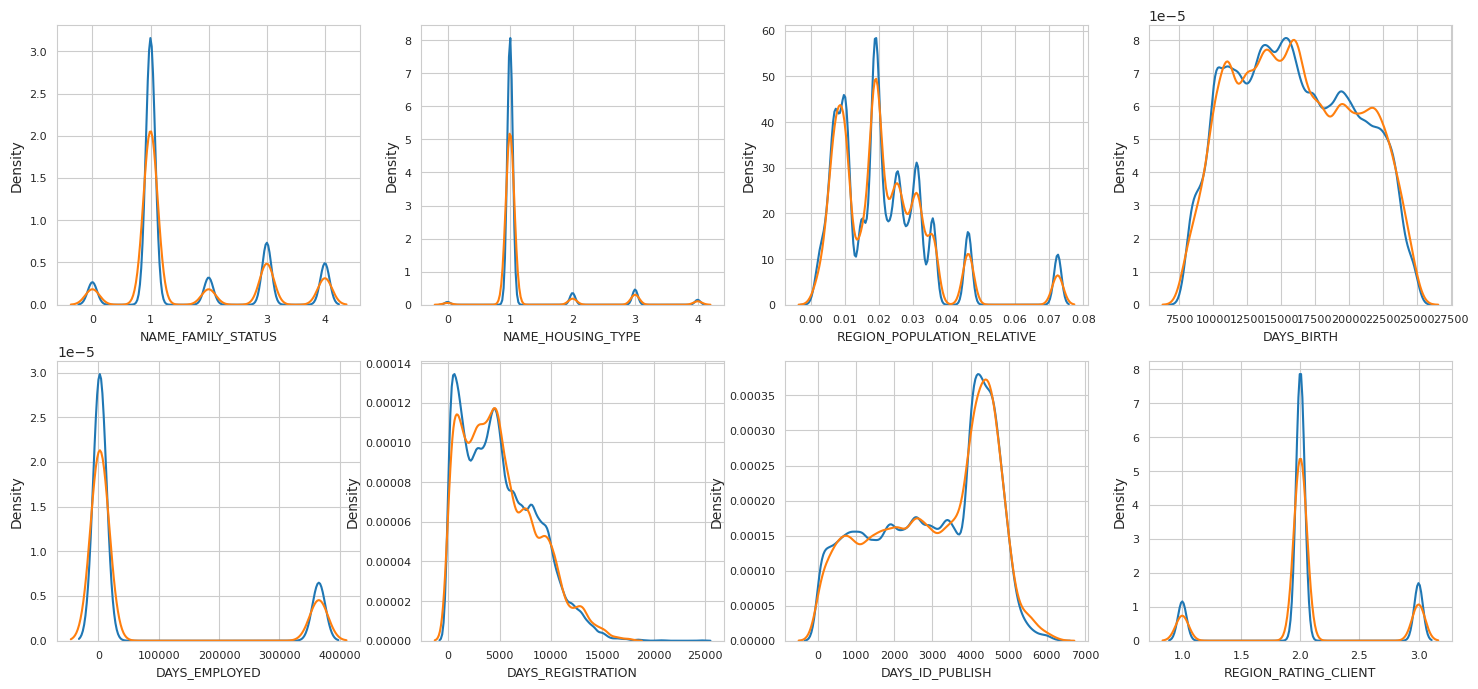

<Figure size 640x480 with 0 Axes>

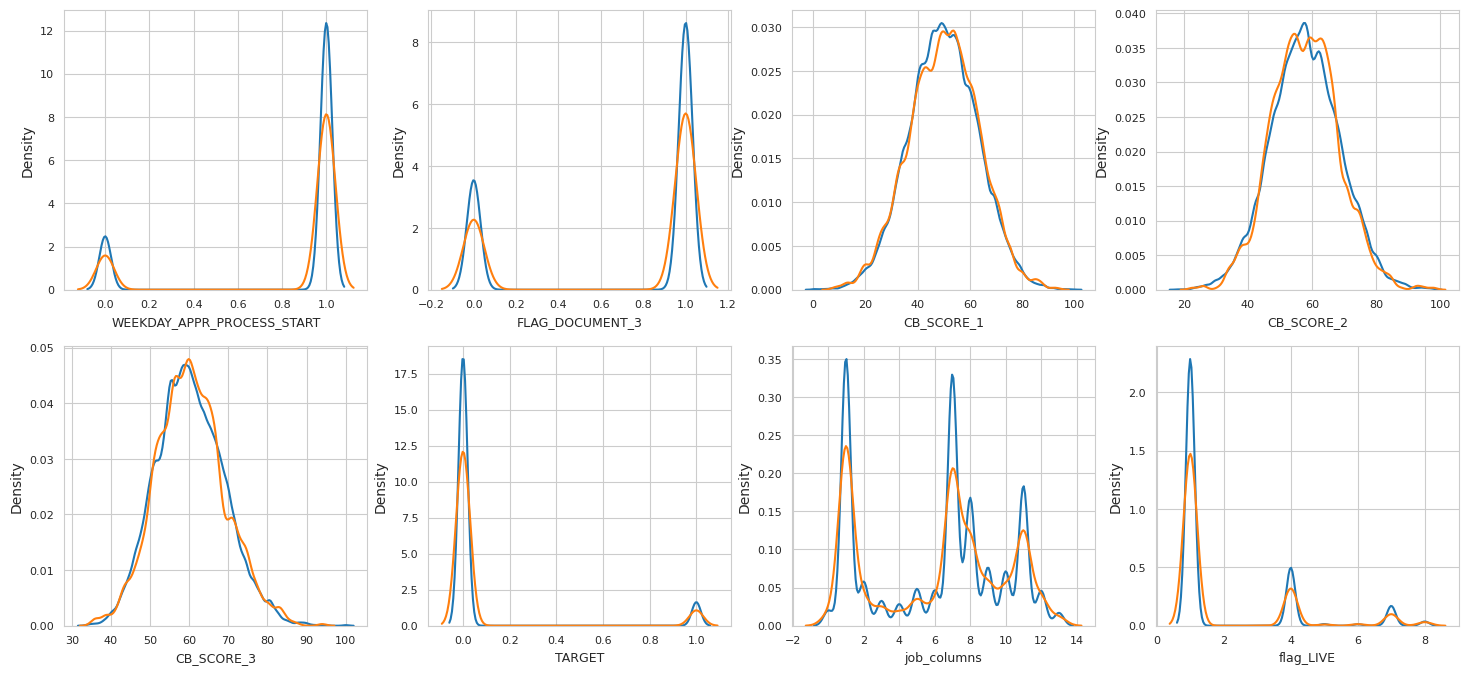

<Figure size 640x480 with 0 Axes>

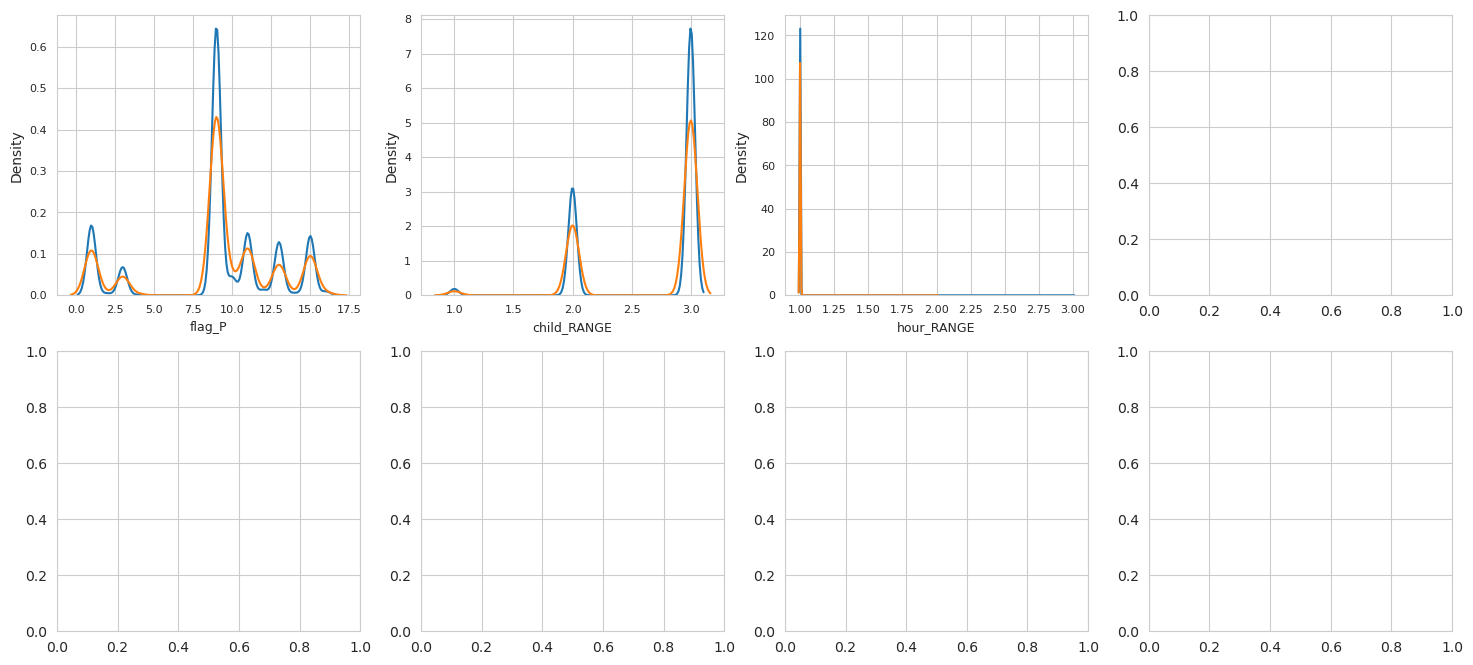

In [29]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw_adjust=.5, label=label1)
        sns.kdeplot(df2[feature], bw_adjust=.5, label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

all_num_features = train_set.select_dtypes(include=[np.number]).columns.tolist()

def plot_all_features(train_set, valid_set, batch_size=8):
    num_batches = len(all_num_features) // batch_size + 1
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        batch_features = all_num_features[start_idx:end_idx]
        plot_feature_distribution(train_set, valid_set, 'train_set', 'valid_set', batch_features)

plot_all_features(train_set, valid_set)

In [30]:
train_set.loc[train_set['NAME_INCOME_TYPE'] == 1, 'DAYS_EMPLOYED'] = 365243
train_set.loc[train_set['NAME_INCOME_TYPE'] == 1, 'DAYS_BIRTH'] = 21823
condition2 = (df['NAME_FAMILY_STATUS'] == 0 ) & (df['CODE_GENDER'].isnull())
df.loc[condition2, 'CODE_GENDER'] = 0

In [31]:
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
train_set_imputed = knn_imputer.fit_transform(train_set)
train_set = pd.DataFrame(train_set_imputed, columns=train_set.columns)

In [32]:
train_set['CODE_GENDER'] = train_set['CODE_GENDER'].apply(lambda x: 0 if x < 0.5 else 1)

<Figure size 640x480 with 0 Axes>

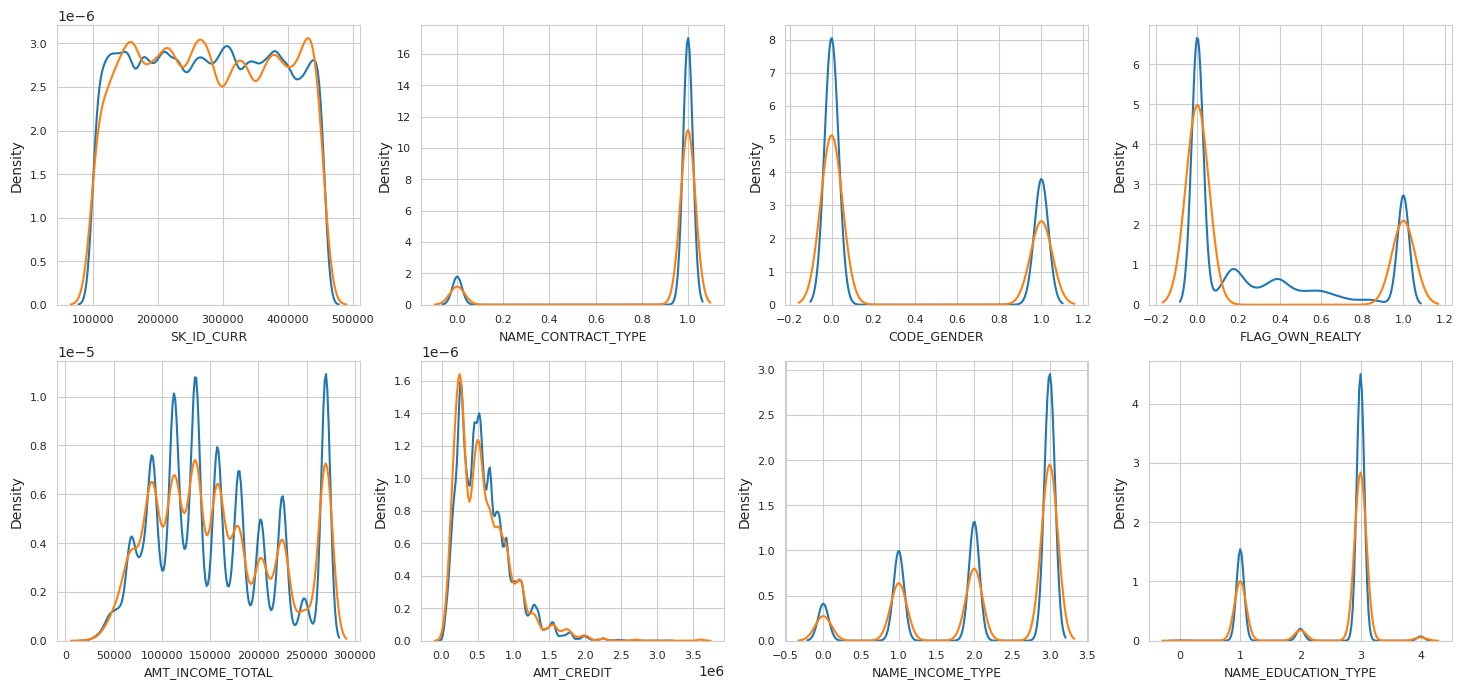

<Figure size 640x480 with 0 Axes>

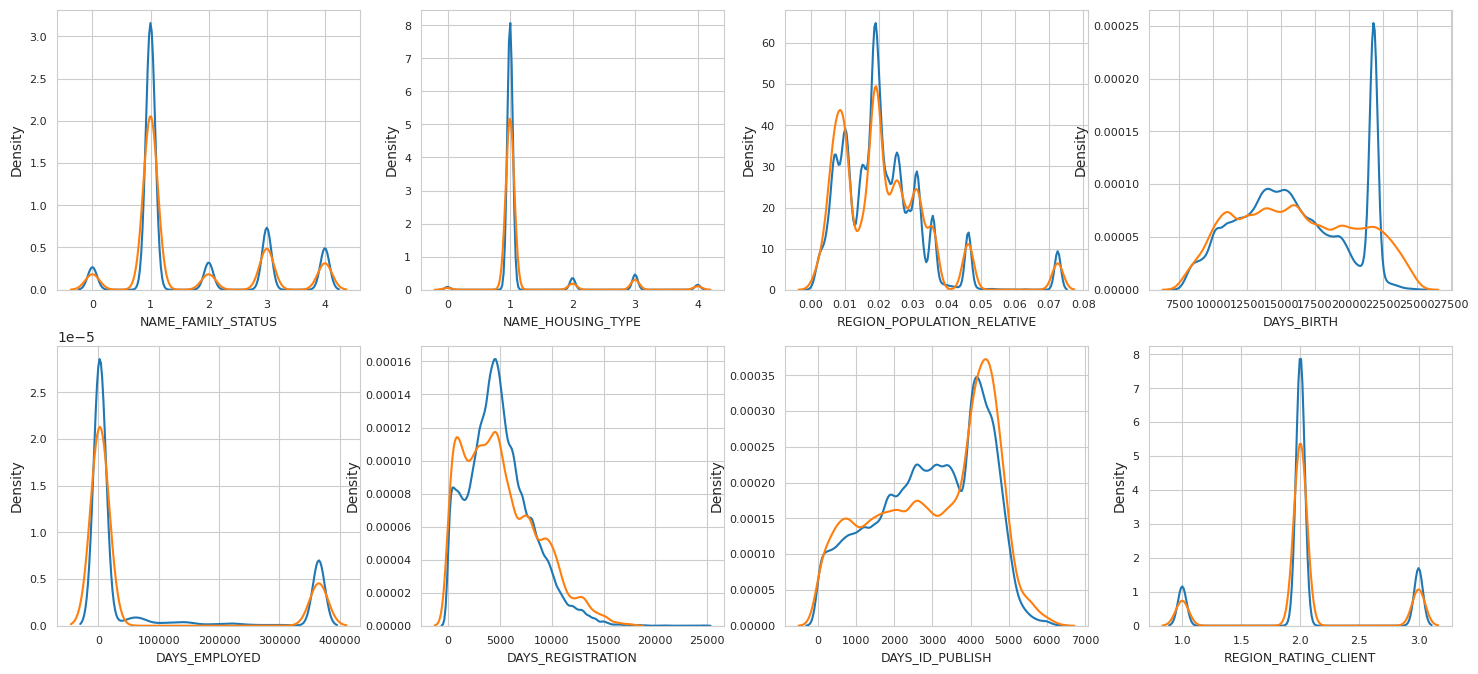

<Figure size 640x480 with 0 Axes>

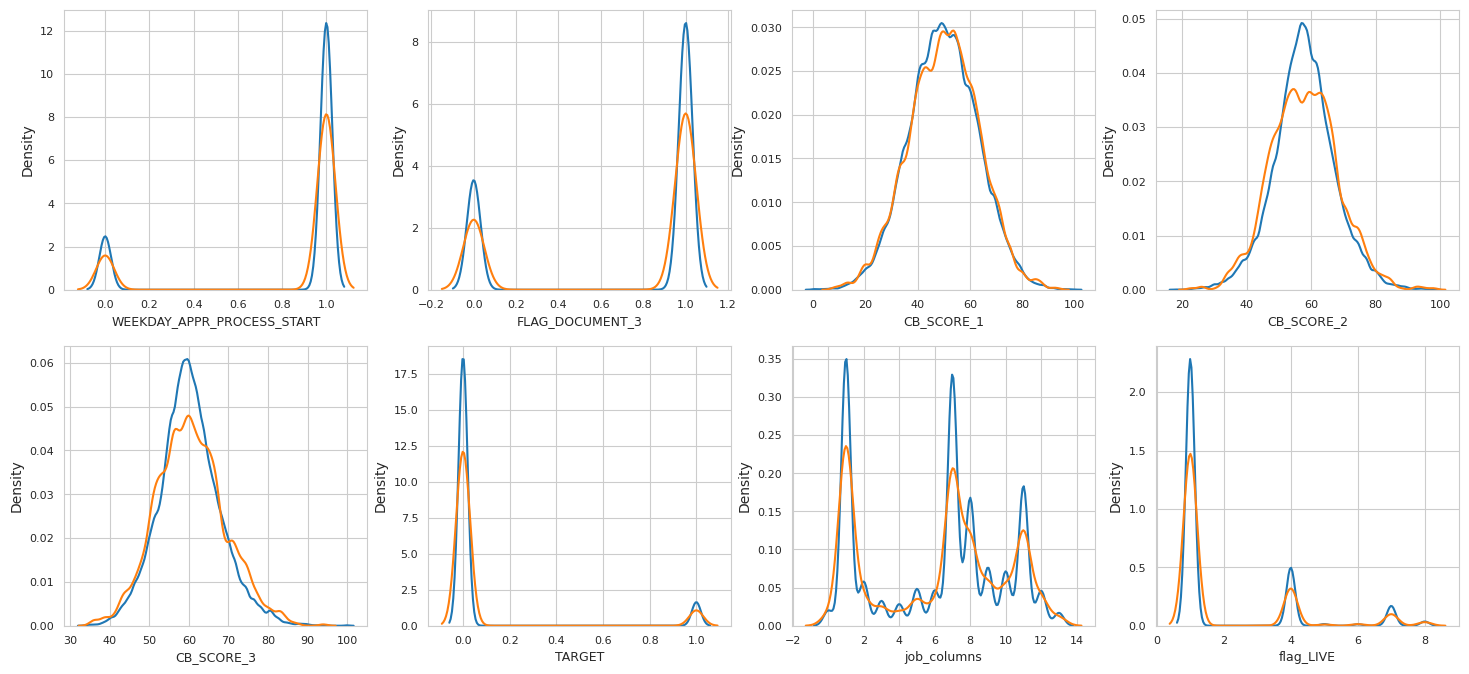

<Figure size 640x480 with 0 Axes>

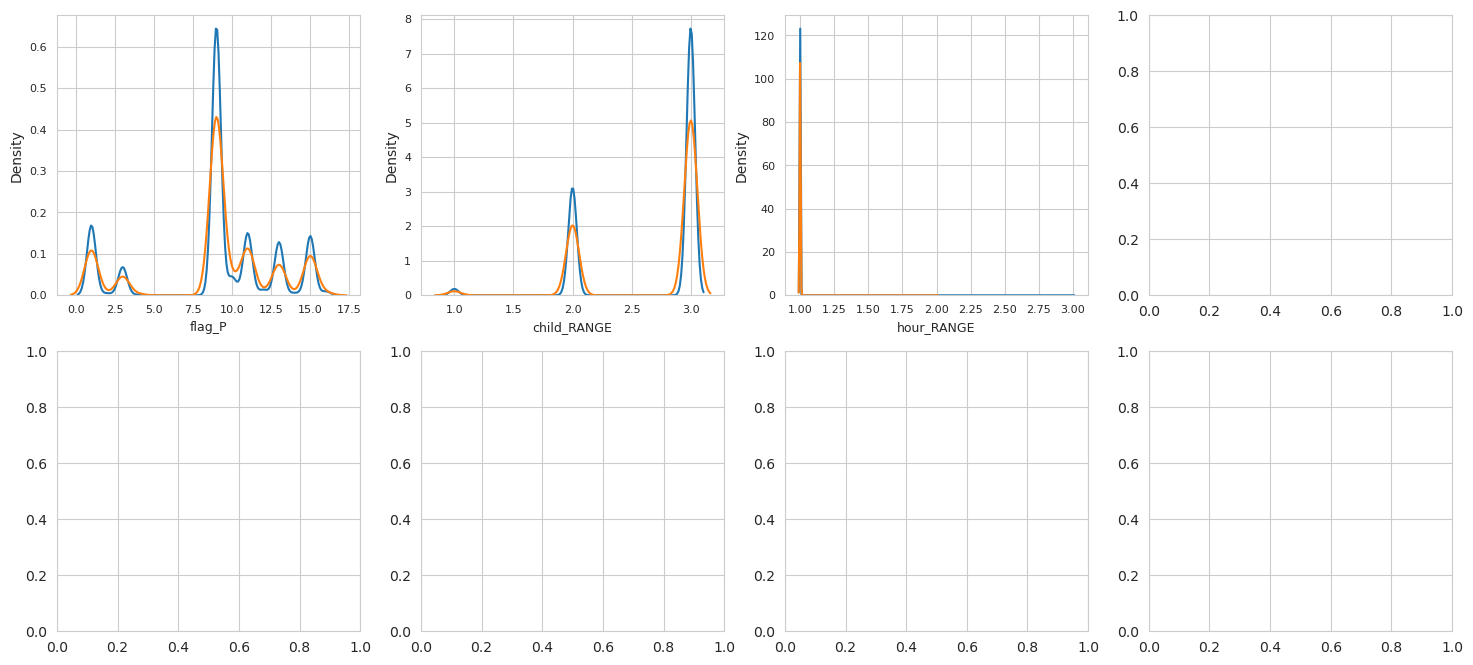

In [33]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw_adjust=.5, label=label1)
        sns.kdeplot(df2[feature], bw_adjust=.5, label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

all_num_features = train_set.select_dtypes(include=[np.number]).columns.tolist()

def plot_all_features(train_set, valid_set, batch_size=8):
    num_batches = len(all_num_features) // batch_size + 1
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        batch_features = all_num_features[start_idx:end_idx]
        plot_feature_distribution(train_set, valid_set, 'train_set', 'valid_set', batch_features)

plot_all_features(train_set, valid_set)

In [34]:
def drop_cols(df):
    df_copy = df.copy()
    df_copy.drop(['REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'FLAG_OWN_REALTY', 'CB_SCORE_2', 'CB_SCORE_3', 'AMT_CREDIT'], axis=1, inplace=True)
    return df_copy

train_set = drop_cols(train_set)
valid_set = drop_cols(valid_set)

In [35]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16004 entries, 0 to 16003
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SK_ID_CURR                  16004 non-null  float64
 1   NAME_CONTRACT_TYPE          16004 non-null  float64
 2   CODE_GENDER                 16004 non-null  int64  
 3   AMT_INCOME_TOTAL            16004 non-null  float64
 4   NAME_INCOME_TYPE            16004 non-null  float64
 5   NAME_EDUCATION_TYPE         16004 non-null  float64
 6   NAME_FAMILY_STATUS          16004 non-null  float64
 7   NAME_HOUSING_TYPE           16004 non-null  float64
 8   DAYS_BIRTH                  16004 non-null  float64
 9   DAYS_EMPLOYED               16004 non-null  float64
 10  DAYS_ID_PUBLISH             16004 non-null  float64
 11  REGION_RATING_CLIENT        16004 non-null  float64
 12  WEEKDAY_APPR_PROCESS_START  16004 non-null  float64
 13  FLAG_DOCUMENT_3             160

In [36]:
def get_age_label(year_birth):
    if year_birth < 27: return 1
    elif year_birth < 34: return 2
    elif year_birth < 38: return 3
    elif year_birth < 41: return 4
    elif year_birth < 55: return 5
    else: return 6

def get_emp_label(year_employed):
    if year_employed < 5: return 1
    elif year_employed < 11: return 2
    elif year_employed < 17: return 3
    else: return 4


def get_pub_label(year_pub):
    if year_pub < 6 : return 1
    elif year_pub < 7.5: return 2
    elif year_pub < 9.5: return 3
    else: return 4


def add_year_columns(df):
    df['YEAR_BIRTH'] = df['DAYS_BIRTH'] / 365
    df['YEAR_EMPLOYED'] = df['DAYS_EMPLOYED'] / 365
    df['YEAR_PUB'] = df['DAYS_ID_PUBLISH'] / 365

add_year_columns(train_set)
add_year_columns(valid_set)


def add_range_year_columns(df):
    df['age_RANGE'] = df['YEAR_BIRTH'].apply(lambda x: get_age_label(x))
    df['emp_RANGE'] = df['YEAR_EMPLOYED'].apply(lambda x: get_emp_label(x))
    df['pub_RANGE'] = df['YEAR_PUB'].apply(lambda x: get_pub_label(x))

add_range_year_columns(train_set)
add_range_year_columns(valid_set)

In [37]:
def emp_sep(df):
    df.loc[df['NAME_INCOME_TYPE'] ==  1 , 'DAYS_EMPLOYED'] = np.nan
    df.loc[df['NAME_INCOME_TYPE'] ==  1 , 'YEAR_EMPLOYED'] = np.nan

emp_sep(train_set)
emp_sep(valid_set)

In [38]:
def emp_birth(df):
    df['emp_birth'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']

emp_birth(train_set)
emp_birth(valid_set)

In [39]:
def age_pub(df):
    df['age_pub'] = df['DAYS_BIRTH'] / df['DAYS_ID_PUBLISH']

age_pub(train_set)
age_pub(valid_set)

In [40]:
def emp_pub(df):
    df['emp_pub'] = df['DAYS_EMPLOYED'] / df['DAYS_ID_PUBLISH']

emp_pub(train_set)
emp_pub(valid_set)

In [41]:
def drop_days(df):
    df.drop(['DAYS_BIRTH','DAYS_EMPLOYED','YEAR_BIRTH','YEAR_EMPLOYED','DAYS_ID_PUBLISH','YEAR_PUB'], axis=1, inplace=True)

drop_days(train_set)
drop_days(valid_set)

In [42]:
def cb_wk_hr(df):
    df['cb_wk_hr'] = df['CB_SCORE_1'] * df['WEEKDAY_APPR_PROCESS_START'] * df['hour_RANGE']

cb_wk_hr(train_set)
cb_wk_hr(valid_set)

In [43]:
agg_list = [
    (['CODE_GENDER','job_columns','NAME_EDUCATION_TYPE'], [
                                              ('CB_SCORE_1', 'mean'),
                                              ('CB_SCORE_1', 'max'),
                                              ('CB_SCORE_1', 'min'),
                                              ('CB_SCORE_1', 'std'),
                                              ('AMT_INCOME_TOTAL', 'mean'),
                                              ('AMT_INCOME_TOTAL', 'min'),
                                              ('AMT_INCOME_TOTAL', 'max'),
                                              ('AMT_INCOME_TOTAL', 'std') ])

  ]

In [44]:
def add_agg_list(df):
    groupby_aggregate_names = []
    for groupby_cols, specs in agg_list:
        group_object = df.groupby(groupby_cols)
        for select, agg in specs:
            groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
            df = df.merge(group_object[select]
                                  .agg(agg)
                                  .reset_index()
                                  .rename(index=str,
                                          columns={select: groupby_aggregate_name})
                                  [groupby_cols + [groupby_aggregate_name]],
                                  on=groupby_cols,
                                  how='left')
            groupby_aggregate_names.append(groupby_aggregate_name)
    return df
train_set = add_agg_list(train_set)
valid_set = add_agg_list(valid_set)

In [45]:
test_set = valid_set.drop('TARGET', axis=1).copy()

In [46]:
revol_indices = np.where(test_set['NAME_CONTRACT_TYPE'] == 0)[0].tolist()

In [47]:
def train_df_with_oof(train_set, test_set, nfolds=5):

    ftr_app = train_set.drop(['SK_ID_CURR','TARGET'], axis=1)
    target_app = train_set['TARGET']


    folds = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=42)

    oof_preds = np.zeros(ftr_app.shape[0])
    test_preds = np.zeros(test_set.shape[0])

    valid_scores = []

    callbacks_list = [
        log_evaluation(50)
    ]

    clf = LGBMClassifier(

        boosting = 'dart',
        objective = 'binary',
        reg_alpha= 0.343606678881187,
        reg_lambda= 10.359354248560779,
        num_leaves= 7,
        colsample_bytree= 0.9653181095378386,
        subsample= 0.9677611683137891,
        subsample_freq= 4,
        min_child_samples= 30,
        max_depth= 2,
        learning_rate= 0.05161480655780597,
        n_estimators=2000
    )


    for fold_idx, (train_idx, valid_idx) in enumerate(folds.split(ftr_app, target_app)):
        print(f"##### iteration {fold_idx} starts")

        train_x = ftr_app.iloc[train_idx, :]
        train_y = target_app.iloc[train_idx]
        valid_x = ftr_app.iloc[valid_idx, :]
        valid_y = target_app.iloc[valid_idx]

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric='auc', callbacks=callbacks_list)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]

        test_preds += clf.predict_proba(test_set.drop('SK_ID_CURR', axis=1), num_iteration=clf.best_iteration_)[:, 1] / nfolds

        valid_score = clf.best_score_['valid_1']['auc']
        valid_scores.append(valid_score)
    mean_valid_score = np.mean(valid_scores)
    print(f"Mean Validation Score: {mean_valid_score}")

    return clf, test_preds, valid_scores, mean_valid_score

clf, test_preds, valid_scores, mean_valid_score = train_df_with_oof(train_set, test_set, nfolds=5)


##### iteration 0 starts
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[50]	training's auc: 0.699646	training's binary_logloss: 0.671811	valid_1's auc: 0.68767	valid_1's binary_logloss: 0.268166
[100]	training's auc: 0.696328	training's binary_logloss: 0.278724	valid_1's auc: 0.683854	valid_1's binary_logloss: 0.351657
[150]	training's auc: 0.702928	training's binary_logloss: 0.267067	valid_1's auc: 0.685331	valid_1's binary_logloss: 0.370172
[200]	training's auc: 0.71126	training's binary_logloss: 0.263798	valid_1's auc: 0.690673	valid_1's binary_logloss: 0.374648
[250]	training's auc: 0.715682	training's binary_logloss: 0.262082	valid_1's auc: 0.693604	valid_1's binary_logloss: 0.377857
[300]	training's auc: 0.720733	training's binary_logloss: 0.260227	valid_1's auc: 0.696821	valid_1's binary_logloss: 0.378499
[350]	training's auc: 0.723151	training's binary_logloss: 0.259785	valid_1's auc: 0.697084	valid_1's binary_loglos

In [48]:
# ############### 하이퍼 파라미터 튜닝 ##################

# !pip install ray
# import lightgbm as lgb
# from ray import tune

# X = train_set.drop('TARGET', axis=1).copy().values
# y = train_set['TARGET'].copy().values

# def train_lgbm(config):
#     auc_list = []
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#     for train_idx, val_idx in skf.split(X, y):
#         X_train, X_val = X[train_idx], X[val_idx]
#         y_train, y_val = y[train_idx], y[val_idx]

#         train_data = lgb.Dataset(X_train, label=y_train)
#         val_data = lgb.Dataset(X_val, label=y_val)

#         gbm = lgb.train(config, train_data, num_boost_round=100, valid_sets=[val_data], verbose_eval=False,early_stopping_rounds=50)
#         preds = gbm.predict(X_val)
#         auc = roc_auc_score(y_val, preds)
#         auc_list.append(auc)

#     avg_auc = np.mean(auc_list)
#     tune.report(auc=avg_auc)

# config = {
#     "objective": "binary",
#     "metric": "auc",
#     "verbosity": -1,
#     "boosting_type": "gbdt",
#     "reg_alpha": tune.loguniform(0.1, 13.0),
#     "reg_lambda": tune.loguniform(0.1, 13.0),
#     "num_leaves": tune.randint(2, 15),
#     "colsample_bytree": tune.uniform(0.1, 1.0),
#     "subsample": tune.uniform(0.0, 1.0),
#     "subsample_freq": tune.randint(0, 30),
#     "min_child_samples": tune.randint(1, 50),
#     "max_depth": tune.randint(1, 6),
#     "learning_rate": tune.loguniform(0.01, 0.09),
#     "n_estimators": 500,
# }

# analysis = tune.run(train_lgbm, config=config, metric="auc", mode="max", num_samples=100)

# print("Best trial config: ", analysis.best_config)
# print("Best trial final validation AUC: ", analysis.best_result["auc"])

In [49]:
roc_auc = roc_auc_score(valid_set['TARGET'], test_preds)
print(f'AUC-ROC Score: {roc_auc:.5f}')

AUC-ROC Score: 0.70306


In [50]:
test_preds[revol_indices] *= 0.8
roc_auc = roc_auc_score(valid_set['TARGET'], test_preds)
print(f'AUC-ROC Score: {roc_auc:.5f}')

AUC-ROC Score: 0.70548


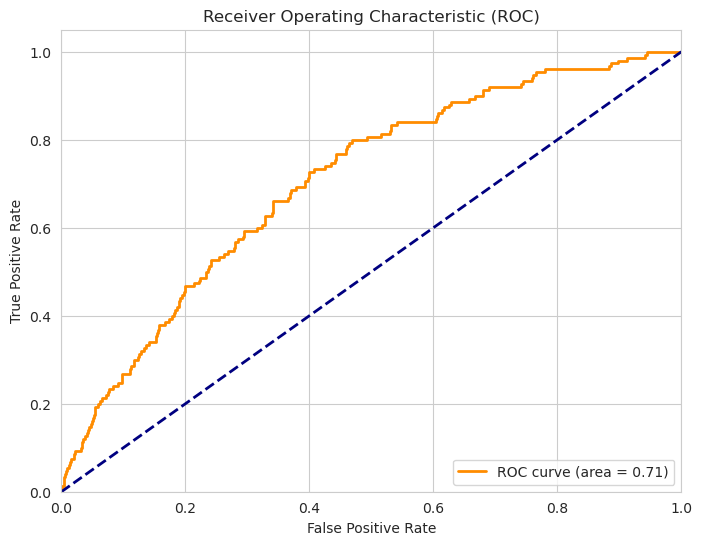

In [51]:
fpr, tpr, thresholds = roc_curve(valid_set['TARGET'], test_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

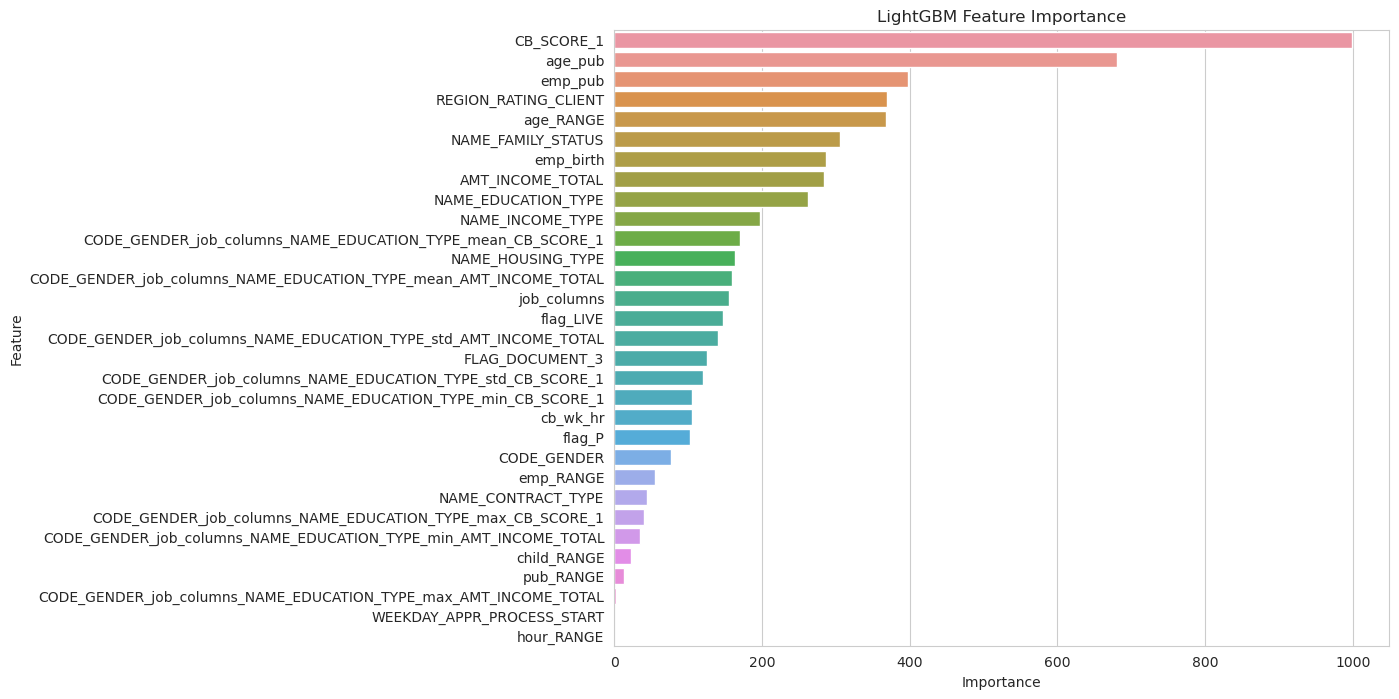

In [52]:
feature_importances = clf.feature_importances_
ftr_app2 = train_set.drop(['SK_ID_CURR','TARGET'], axis=1)
feature_names = ftr_app2.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('LightGBM Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

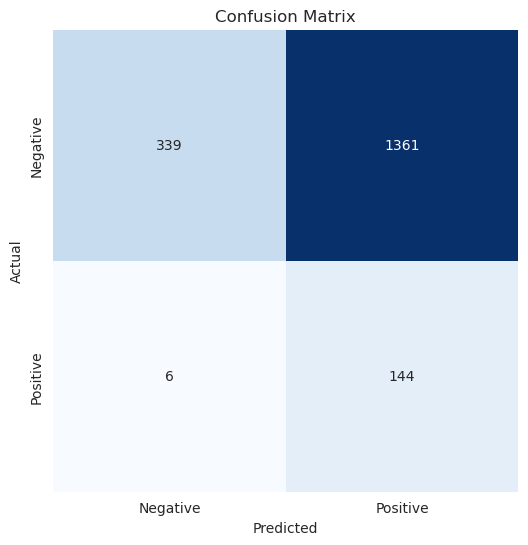

In [53]:
threshold = 0.3
binary_preds = (test_preds > threshold).astype(int)

conf_matrix = confusion_matrix(valid_set['TARGET'], binary_preds)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [54]:
###############  Hidden dataset ##############

In [ ]:
############### 전처리 #########################
prep(hd)
hd = drop_cols(hd)
add_year_columns(hd)
add_range_year_columns(hd)
emp_sep(hd)
emp_birth(hd)
age_pub(hd)
emp_pub(hd)
drop_days(hd)
cb_wk_hr(hd)
hd = add_agg_list(hd)
revol_hd_indices = np.where(hd['NAME_CONTRACT_TYPE'] == 0)[0].tolist()

In [ ]:
hd.info()

In [ ]:
clf, test_preds, valid_scores, mean_valid_score = train_df_with_oof(train_set, hd, nfolds=5)

In [ ]:
test_preds[revol_hd_indices] *= 0.8

In [ ]:
roc_auc = roc_auc_score(hd_ans, test_preds)
print(f'AUC-ROC Score: {roc_auc:.5f}')

In [ ]:
test_preds

In [ ]:
################# Submission ###################
submission_df = pd.DataFrame({
    "SK_ID_CURR": hd["SK_ID_CURR"],
    "TARGET": test_preds
})

submission_df.to_csv("submission.csv", index=False)
################# Submission ###################

In [ ]:
submission_df.head()